In [48]:
import os

import nibabel as nib
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import itertools


def get_frac_type(label):
    if label == 1:
        return 'displaced'
    if label == 2:
        return 'non-displaced'
    if label == 3:
        return 'buckle'
    if label == 4:
        return 'segmental'
    if label == -1:
        return 'undefined'

rib_frac_types = {'displaced':0, 
                  'non-displaced':0, 
                  'buckle':0,
                  'segmental':0,
                  'undefined':0}
rib_data = defaultdict(list)
nr_frac = defaultdict(int)
for index, row in pd.read_csv('train/ribfrac-train-info-1.csv').iterrows():
    rib_data[row[0]].append(row[2])
    nr_frac[row[0]] += 1
    if row[2] != 0:
        rib_frac_types[get_frac_type(row[2])] += 1
        
for index, row in pd.read_csv('train/ribfrac-train-info-2.csv').iterrows():
    rib_data[row[0]].append(row[2])
    nr_frac[row[0]] += 1
    if row[2] != 0:
        rib_frac_types[get_frac_type(row[2])] += 1
        
#print(rib_data)
print(nr_frac)
#print(rib_frac_types)

total_rib_frac = sum(rib_frac_types.values())

avg_frac = total_rib_frac/len(nr_frac)
print('average fractures', avg_frac)
print('total fractures',total_rib_frac)

defaultdict(<class 'int'>, {'RibFrac1': 3, 'RibFrac2': 10, 'RibFrac3': 13, 'RibFrac4': 7, 'RibFrac5': 3, 'RibFrac6': 16, 'RibFrac7': 7, 'RibFrac8': 12, 'RibFrac9': 17, 'RibFrac10': 9, 'RibFrac11': 3, 'RibFrac12': 7, 'RibFrac13': 10, 'RibFrac14': 7, 'RibFrac15': 10, 'RibFrac16': 16, 'RibFrac17': 19, 'RibFrac18': 10, 'RibFrac19': 24, 'RibFrac20': 4, 'RibFrac21': 18, 'RibFrac22': 4, 'RibFrac23': 10, 'RibFrac24': 6, 'RibFrac25': 20, 'RibFrac26': 9, 'RibFrac27': 5, 'RibFrac28': 10, 'RibFrac29': 5, 'RibFrac30': 16, 'RibFrac31': 11, 'RibFrac32': 17, 'RibFrac33': 7, 'RibFrac34': 16, 'RibFrac35': 16, 'RibFrac36': 6, 'RibFrac37': 9, 'RibFrac38': 5, 'RibFrac39': 4, 'RibFrac40': 6, 'RibFrac41': 7, 'RibFrac42': 12, 'RibFrac43': 20, 'RibFrac44': 10, 'RibFrac45': 7, 'RibFrac46': 12, 'RibFrac47': 5, 'RibFrac48': 3, 'RibFrac49': 4, 'RibFrac50': 6, 'RibFrac51': 7, 'RibFrac52': 12, 'RibFrac53': 4, 'RibFrac54': 25, 'RibFrac55': 4, 'RibFrac56': 5, 'RibFrac57': 5, 'RibFrac58': 14, 'RibFrac59': 11, 'RibFrac6

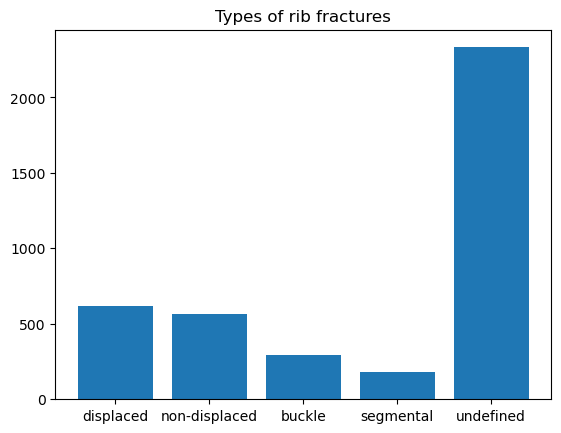

In [4]:
plt.bar(rib_frac_types.keys(),rib_frac_types.values())
plt.title('Types of rib fractures')
plt.show()

In [82]:
def process_folder(folder_name, nr_frac, data_root: str, csv_filename: str = "data_info.csv"):
    frac_data = defaultdict(lambda: {'height':0,'size_x':0,'size_y':0,'size_z':0})
    data = []
    set_ = (
        "train"
        if "train" in folder_name
        else "val"
        if "val" in folder_name
        else "test"
    )
    for filename in tqdm(
        os.listdir(os.path.join(data_root, folder_name)), desc=folder_name
    ):
        f = os.path.join(data_root, folder_name, filename)
        if filename.endswith("label.nii.gz"):
            data_dev = []
            scan = nib.load(f).get_fdata().T.astype(float)
            label_f = f.replace("image", "label")
            labels = nib.load(label_f).get_fdata().T.astype(int)
            for i, slice in enumerate(scan):
                data_temp = [
                            os.path.join(folder_name, filename),
                            i,
                            set_,
                            np.unique(labels[i]).tolist(),
                            slice.min(),
                            slice.max(),
                            slice.mean(),
                            slice.std(),
                            ]
                data_dev.append(data_temp)
                data.append(data_temp)
            df_slice = pd.DataFrame(
            data_dev,
            columns=[
                "img_filename",
                "slice_idx",
                "set",
                "labels",
                "min",
                "max",
                "mean",
                "std",
            ],
            )
            fn = filename.split('-')[0]
            for i in range(1,nr_frac[fn]):
                idx = []
                for ind in df_slice.index:
                    if i in df_slice['labels'][ind]:
                        idx.append(df_slice['slice_idx'][ind])
                frac_data[fn+'frac'+str(i)]['height'] = (idx[-1] + idx[0])/ 2
                frac_data[fn+'frac'+str(i)]['size_z'] = idx[-1] - idx[0]

    df = pd.DataFrame(
        data,
        columns=[
            "img_filename",
            "slice_idx",
            "set",
            "labels",
            "min",
            "max",
            "mean",
            "std",
        ],
    )
    return df, frac_data

df,data = process_folder('train',nr_frac,'')
print(data)
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.precision', 3, ): print(df)


train: 100%|█████████████████████████████████████████████████████████████████████████| 842/842 [14:35<00:00,  1.04s/it]


defaultdict(<function process_folder.<locals>.<lambda> at 0x000001CBA6B6DEE0>, {'RibFrac1frac1': {'height': 230.0, 'size_x': 0, 'size_y': 0, 'size_z': 16}, 'RibFrac1frac2': {'height': 202.5, 'size_x': 0, 'size_y': 0, 'size_z': 17}, 'RibFrac10frac1': {'height': 275.5, 'size_x': 0, 'size_y': 0, 'size_z': 11}, 'RibFrac10frac2': {'height': 256.0, 'size_x': 0, 'size_y': 0, 'size_z': 10}, 'RibFrac10frac3': {'height': 273.5, 'size_x': 0, 'size_y': 0, 'size_z': 13}, 'RibFrac10frac4': {'height': 233.5, 'size_x': 0, 'size_y': 0, 'size_z': 15}, 'RibFrac10frac5': {'height': 245.5, 'size_x': 0, 'size_y': 0, 'size_z': 13}, 'RibFrac10frac6': {'height': 223.0, 'size_x': 0, 'size_y': 0, 'size_z': 14}, 'RibFrac10frac7': {'height': 199.5, 'size_x': 0, 'size_y': 0, 'size_z': 19}, 'RibFrac10frac8': {'height': 181.0, 'size_x': 0, 'size_y': 0, 'size_z': 14}, 'RibFrac100frac1': {'height': 114.5, 'size_x': 0, 'size_y': 0, 'size_z': 9}, 'RibFrac100frac2': {'height': 123.5, 'size_x': 0, 'size_y': 0, 'size_z': 7}

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)

